<a href="https://colab.research.google.com/github/TAMIDSpiyalong/Introduction-to-Machine-Learning-for-Energy/blob/main/Lecture_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning



Transfer learning is a machine learning technique where a model trained on one task or domain is reused and adapted to another related task or domain. Instead of starting the training of a new model from scratch, transfer learning leverages the knowledge learned from a source task to improve the learning of a new task. This approach is particularly useful when the target task has limited labeled data or when training a model from scratch on the target task is computationally expensive.

## Objectives

1. Use PyTorch to load the dataset and test a pre-trained ResNet model
2. Use transfer learning to train a model to classify different dog breeds
3. Compare the results of transfer learning to training from scratch

## Pre-trained model

In the context of deep learning, pre-trained weights are commonly used in transfer learning. By leveraging these pre-trained weights, the model starts with learned features that are useful for various computer vision tasks, such as image classification, object detection, or segmentation.

Typically, pre-trained weights are obtained from models trained on large-scale datasets, such as [ImageNet](https://www.image-net.org/) and [COCO](https://cocodataset.org/#home), which contains millions of labeled images belonging to thousands of different categories. Models like VGG, ResNet, Inception, and others have been trained on ImageNet and have learned to recognize a wide range of visual features.

In this lab we use PyTorch becuase the smallest ResNet18 is not available on Tensorflow. To save training time, a small model size is helpful. ResNet is one of the best performing classification models. ResNet family is available in several variations, including ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152, where the numbers represent the number of layers in each variant.

In [ ]:
import torch
import numpy as np
from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt
import time
import os
import seaborn as sn
import pandas as pd
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Some images are not stardard giving warnings, which is too much information.
import warnings
warnings.filterwarnings("ignore")

We need to install some package to visualize Pytorch models. This is not as nice as Keras.

In [ ]:
! pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=236fc8fde9e11ba3cf450373d654a7c569ff6d15665d10894e7193aa4497b9f1
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=False)

# Display the model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# Use a sample input tensor to create the computation graph
sample_input = torch.randn((1, 3, 224, 224)).to(device)
dot = make_dot(resnet18(sample_input), params=dict(resnet18.named_parameters()))

# Save the computation graph to a file (optional)
dot.format = 'png'
dot.render("resnet18_computation_graph")


'resnet18_computation_graph.png'

You can find the ResNet visualization `png` in our folder. Pay attention to the residual blocks that is the core innovation of ResNet, which is the use of skip connections or residual blocks. These connections allow information to skip one or more layers, making it easier to train deep networks. This helps in mitigating the vanishing gradient problem and accelerates the convergence of the training process.

In [ ]:
# we do not have gpu on colab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Download Dog Breed Image Data

This is the dataset we prepared for you. All the images are seperated by folder names.

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=1syxo1QtezuTnQsklIEj0OougzkZwRMse')


Downloading...
From: https://drive.google.com/uc?export=download&id=1syxo1QtezuTnQsklIEj0OougzkZwRMse
To: /content/Dog_Breed_Data.zip
100%|██████████| 64.9M/64.9M [00:02<00:00, 31.8MB/s]


'Dog_Breed_Data.zip'

In [ ]:
# https://drive.google.com/file/d/1cWggDLdX6ho9HejHH8t3MS5lt6wCjD5l/view?usp=drive_link
# https://drive.google.com/file/d/1syxo1QtezuTnQsklIEj0OougzkZwRMse/view?usp=drive_link

In [ ]:
! unzip  Dog_Breed_Data.zip

Archive:  Dog_Breed_Data.zip
   creating: Dog_Breed_Data/Beagle/
  inflating: Dog_Breed_Data/Beagle/1.file_23012_beagle.jpg  
  inflating: Dog_Breed_Data/Beagle/10.beagle_upsy.jpg  
  inflating: Dog_Breed_Data/Beagle/10.canine.png  
  inflating: Dog_Breed_Data/Beagle/11.500x500-07_beagle-1523993536226.png  
  inflating: Dog_Breed_Data/Beagle/11.beagle-standing-in-a-frosty-field-on-a-cold-morning.jpg  
  inflating: Dog_Breed_Data/Beagle/12.how-to-potty-train-a-beagle-puppy.png  
  inflating: Dog_Breed_Data/Beagle/12.image.jpg  
  inflating: Dog_Breed_Data/Beagle/13.14_h.png  
  inflating: Dog_Breed_Data/Beagle/14.81wezpj9bal._ac_sl1500_.jpg  
  inflating: Dog_Breed_Data/Beagle/14.beagle-vs-basset-hound.png  
  inflating: Dog_Breed_Data/Beagle/16.beagle-e1587511922360.jpg  
  inflating: Dog_Breed_Data/Beagle/16.untitled-design-5.png  
  inflating: Dog_Breed_Data/Beagle/17.beagle.png  
  inflating: Dog_Breed_Data/Beagle/17.beagle-dog-breed-of-the-month-1619614746.jpg  
  inflating: Dog_Br

## Prepare Image Data

The DataLoader is an essential component in deep learning frameworks, such as PyTorch and TensorFlow, that facilitates the efficient and convenient loading of data during training and evaluation. It provides an interface to handle data loading and batching, which is crucial for large datasets and complex models.

### Image Transformation

In PyTorch, image transformations are essential preprocessing steps used in computer vision tasks to enhance the diversity and quality of data before feeding it into a neural network. The transforms module in PyTorch provides a wide range of transformations, such as resizing, cropping, flipping, normalization, and more. These transformations can be easily combined using transforms.Compose() to create a pipeline of preprocessing steps tailored to specific dataset requirements.

In [ ]:
# this is the mean and standard deviation for imagenet dataset
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
#         transforms.RandomResizedCrop(224),
        transforms.Resize((224,224)),
#         transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

### Image Dataloader

torchvision.datasets.ImageFolder is a dataset class from the torchvision library, specially designed for working with image data organized in a structured folder format. Its purpose is to facilitate the loading of image datasets for training and evaluation when the data is divided into separate folders, each representing a class, and containing images belonging to that class.

In this lab, the folder names serve as the labels for each breed. The transform variable determines the preprocessing transformations applied to each image before it is used in the model. By printing out the attributes with essential information like image paths and labels, we can inspect the dataset without actually loading the data.

Although ImageFolder is a convenient option for basic tasks, more advanced object detection and segmentation tasks require defining custom datasets to load images and annotations. These tasks often involve more complex data handling, which can be achieved through custom dataset classes tailored to specific requirements.

In [ ]:
images = datasets.ImageFolder('Dog_Breed_Data',transform)

In [ ]:
images.imgs[:5]

[('Dog_Breed_Data/Beagle/1.file_23012_beagle.jpg', 0),
 ('Dog_Breed_Data/Beagle/10.beagle_upsy.jpg', 0),
 ('Dog_Breed_Data/Beagle/10.canine.png', 0),
 ('Dog_Breed_Data/Beagle/11.500x500-07_beagle-1523993536226.png', 0),
 ('Dog_Breed_Data/Beagle/11.beagle-standing-in-a-frosty-field-on-a-cold-morning.jpg',
  0)]

In [ ]:
images.classes

['Beagle',
 'Broad Collie',
 'Corgi',
 'French Bulldog',
 'Golden Retriever',
 'Labrador Retriever',
 'Mini Australian Shepherd']

### Data Split for Training, Validation, and Testing

In machine learning and deep learning workflows, the dataset is usually divided into three subsets: the training set, which is used to train the model and adjust its parameters; the validation set, which aids in model selection and hyperparameter tuning; and the test set, which provides an unbiased evaluation of the model's performance on unseen data. A common split is 80%, 10%, and 10%.

In [ ]:
data_size = len(images.imgs)
train_size = int(data_size*0.8)
val_size = (data_size-train_size)//2
test_size = data_size-train_size-val_size
train_set, val_set, test_set = data.random_split(images, (train_size,val_size,test_size))


In [ ]:
data_size,test_size,val_size

(246, 25, 25)

DataLoader in PyTorch is a utility class that facilitates efficient data loading and iteration during training or evaluation. It works in conjunction with custom datasets or built-in datasets like ImageFolder, automatically batching the data, shuffling it randomly to introduce diversity during training, and enabling parallel data loading with multiple worker processes to speed up the process. This class plays a crucial role in optimizing training performance and handling large datasets, ensuring that deep learning models can efficiently process data in batches, leading to faster and more effective model training.

In [ ]:
from torch.utils.data import DataLoader

batch_size=4
class_names = images.classes

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)


### visualize the input examples

torch.Size([224, 224])
tensor([0, 1, 0, 2])


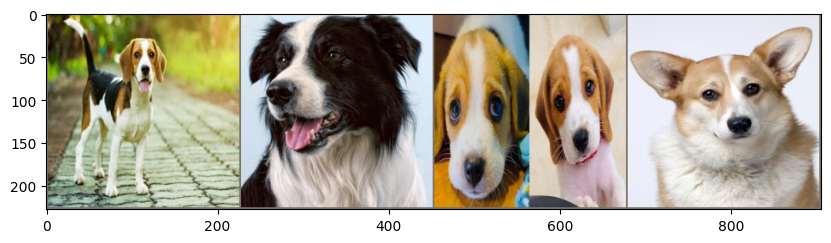

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean # correct the nornalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
print(inputs[0][0].shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(10,5))
imshow(out, title='Input Examples')
print(classes)

## Train a Model without Pre-trained Weights

### Load Model and Modity

We can load the print out the model. We can also print each layter and see the parameters.

In [ ]:
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=False)

print(model.layer1)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


The last layer of the pre-trained ResNet18 has the output dimension of 1000 corresponding to the 1000 classes in ImageNet. We need to modify this layer to suit our task which has only 7 dog breeds. This is done by assigning `model.fc` = `nn.Linear` with `len(class_names)` dimension output.

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

In this code snippet, the provided model is moved to the specified device (CPU or GPU) using model.to(device), enabling the model's computations to be performed on that device. Next, the CrossEntropyLoss is defined as the criterion, which is the loss function used for multi-class classification tasks. The optimizer chosen for updating the model's weights during training is Stochastic Gradient Descent (SGD) with a learning rate of 0.001 and momentum of 0.9. Lastly, a learning rate scheduler is created using lr_scheduler.StepLR, which decreases the learning rate by a factor of 0.1 every 5 epochs. This strategy helps the model converge more effectively during training, adjusting the learning rate over time to optimize the model's performance.

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

We are training a model without pre-trained weights to establish a baseline understanding of its performance from random initialization. The following code is in one cell but each small block is marked with comments. This tells more than Keras fit function.

For each batch every epoch, the some inputs and labels are loaded to calculated the loss and accuracy. The optimizer then updates the weights using the partial derivitives. Press control+M+L to show line numbers. Pay attention to the green arrow on the left pointing at which part of the code is been excuted.

Each epoch has a train and validation phase and they are very similar. Try to understand one section and the other should be easy to follow. After the training is done, you can study all the variables such as the inputs and labels. Play with it to make sure you can follow.

In [ ]:
since = time.time()

best_acc = 0.0
num_epochs=5

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model.train()  # Set model to training mode
    train_running_loss = 0.0
    train_running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)
    scheduler.step()

    train_epoch_loss = train_running_loss / len(train_set)
    train_accuracy = train_running_corrects.double() / len(train_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")


    # Each epoch has a validation phase

    model.eval()   # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data.
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_set)
    val_accuracy = val_running_corrects.double() / len(val_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

        # deep copy the model
    if  val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model.state_dict()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


Epoch 0/4
----------
Epoch 1/5, Training Loss: 2.0394, Training Accuracy: 0.20%
Epoch 1/5, Validation Loss: 2.0645, validation Accuracy: 0.20%
Epoch 1/4
----------
Epoch 2/5, Training Loss: 2.0110, Training Accuracy: 0.27%
Epoch 2/5, Validation Loss: 1.8870, validation Accuracy: 0.36%
Epoch 2/4
----------
Epoch 3/5, Training Loss: 1.7727, Training Accuracy: 0.32%
Epoch 3/5, Validation Loss: 2.3510, validation Accuracy: 0.16%
Epoch 3/4
----------
Epoch 4/5, Training Loss: 1.9322, Training Accuracy: 0.27%
Epoch 4/5, Validation Loss: 2.1554, validation Accuracy: 0.40%
Epoch 4/4
----------
Epoch 5/5, Training Loss: 1.9603, Training Accuracy: 0.26%
Epoch 5/5, Validation Loss: 1.8505, validation Accuracy: 0.40%
Training complete in 0m 36s
Best val Acc: 0.400000


In [ ]:
for inputs, labels in train_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

print(inputs.size(),labels.size())

torch.Size([4, 3, 224, 224]) torch.Size([4])


The model learns to some degree but the training and validation accuracy are pretty low. The visualization also shows that the model makes low confidence predictions.

### Result Visualization

In [ ]:
def visualize_model(model, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20,20))
    sm = torch.nn.Softmax()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            l=labels
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            confidence = np.amax(np.array(sm(outputs.cpu())),1)
#             break
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.set_xlabel('Groun Truth: {}'.format(class_names[l[j]]))
                ax.set_ylabel('Prediction: {}'.format(class_names[preds[j]]))
                ax.set_title('Confidence {:.2f}'.format(confidence[j]))

                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)
                if images_so_far == num_images:
                    return


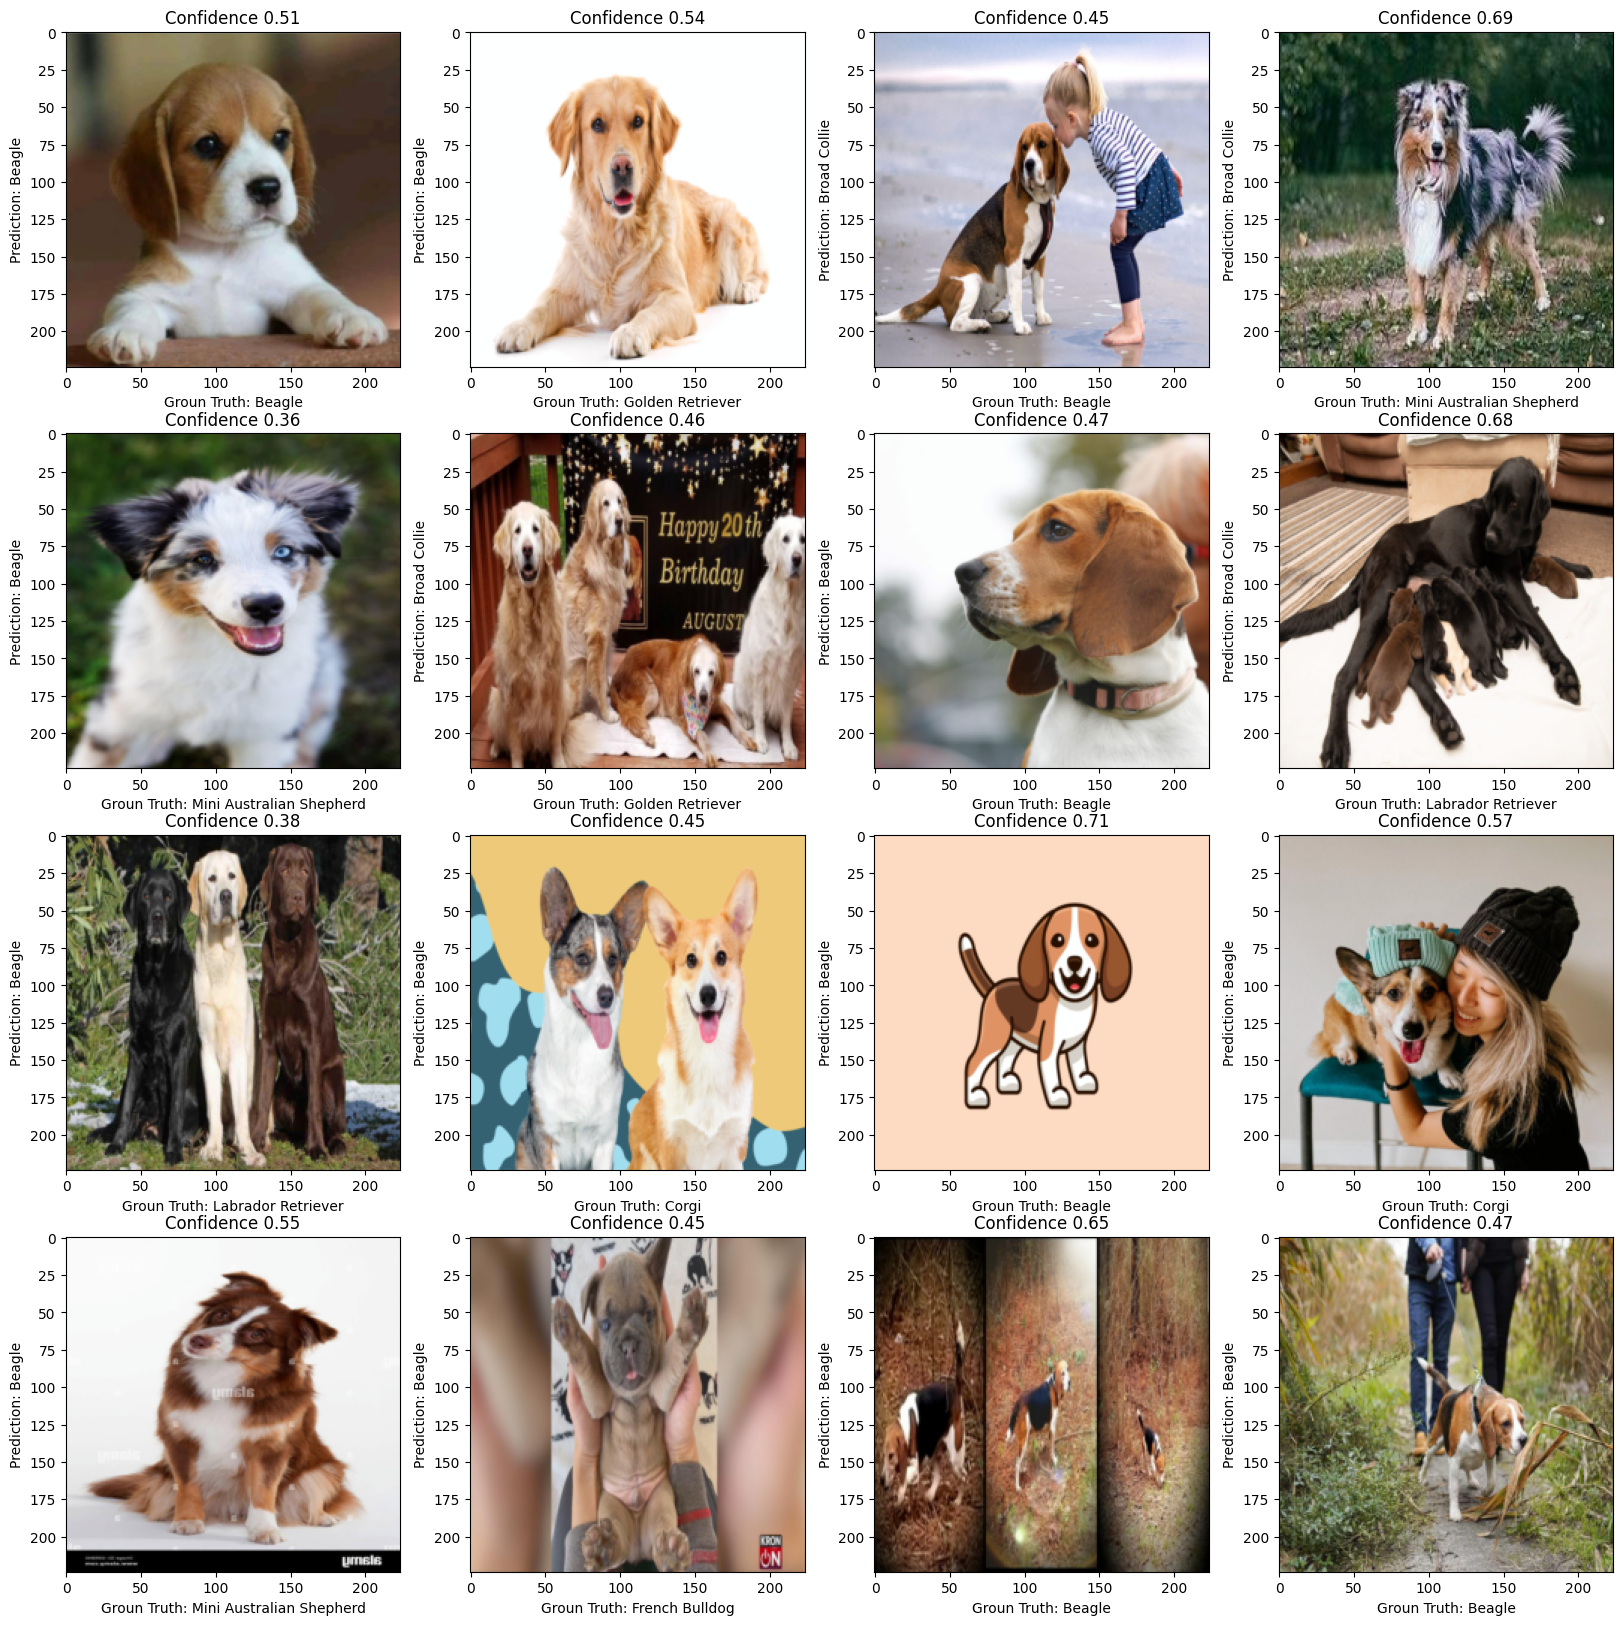

In [ ]:
visualize_model(model)

## Train a Model with Pretrained Weights

This time we load the pretrained weight and see the difference. Everything else remains the same except `model = models.resnet18(pretrained=True)`.

In [ ]:
from torch.optim import lr_scheduler

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 27.2MB/s]


In [ ]:
since = time.time()

best_acc = 0.0
num_epochs=5

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model.train()  # Set model to training mode
    train_running_loss = 0.0
    train_running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)
    scheduler.step()

    train_epoch_loss = train_running_loss / len(train_set)
    train_accuracy = train_running_corrects.double() / len(train_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")


    # Each epoch has a validation phase

    model.eval()   # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data.
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_set)
    val_accuracy = val_running_corrects.double() / len(val_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

        # deep copy the model
    if  val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model.state_dict()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


Epoch 0/4
----------
Epoch 1/5, Training Loss: 1.4360, Training Accuracy: 0.51%
Epoch 1/5, Validation Loss: 0.6275, validation Accuracy: 0.72%
Epoch 1/4
----------
Epoch 2/5, Training Loss: 0.6691, Training Accuracy: 0.79%
Epoch 2/5, Validation Loss: 0.3313, validation Accuracy: 0.76%
Epoch 2/4
----------
Epoch 3/5, Training Loss: 0.3991, Training Accuracy: 0.89%
Epoch 3/5, Validation Loss: 0.4649, validation Accuracy: 0.84%
Epoch 3/4
----------
Epoch 4/5, Training Loss: 0.3691, Training Accuracy: 0.87%
Epoch 4/5, Validation Loss: 0.3000, validation Accuracy: 0.84%
Epoch 4/4
----------
Epoch 5/5, Training Loss: 0.3179, Training Accuracy: 0.92%
Epoch 5/5, Validation Loss: 0.2517, validation Accuracy: 0.92%
Training complete in 0m 23s
Best val Acc: 0.920000


The benefits of transfer learning are evident as the accuracies have significantly improved. However, it's essential to consider that the dataset is small, making it easier to achieve high accuracy percentages. The training process has been enhanced, leading to better model performance and improved visualizations. The model's increased confidence in true positive cases further underscores the effectiveness of transfer learning, especially when dealing with limited data. For those interested, the file can be downloaded for further exploration or experimentation with transfer learning on individual pets, resembling the functionality of phone face unlock for recognizing specific individuals. This could be useful, for instance, in unlocking a dog door exclusively for one's own pet.

### Saving the Best Model and Load

In PyTorch, when saving and loading models, it is essential to use the model.state_dict() method instead of the model object itself. The state_dict() method returns a dictionary containing all the learnable parameters of the model, making it space-efficient when saving models to disk. This approach ensures compatibility across different model architectures and PyTorch versions, as it allows you to easily re-create the model and load the saved parameters into models with the same architecture.

In [ ]:
torch.save(best_model, 'best_model.pth')

We can now load the best model based on validation dataset and visualize the results. But we cannot directly load ResNet because we changed the last layer of the model. So we load a ResNet18 and modify the model.

In [ ]:
model = models.resnet18(pretrained=False)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

model.load_state_dict(torch.load('best_model.pth'))
model.to(device);

## Output Format

For multi-class classification tasks, the output format is often a vector or matrix containing probabilities for each class in the dataset. Each element of the vector or matrix represents the probability of the input belonging to a particular class. The sum of probabilities across all classes will be equal to 1. The model predicts the class with the highest probability as the final classification.

This is a Mini Australian Shepherd


Text(0.5, 1.0, 'Confidence for each class')

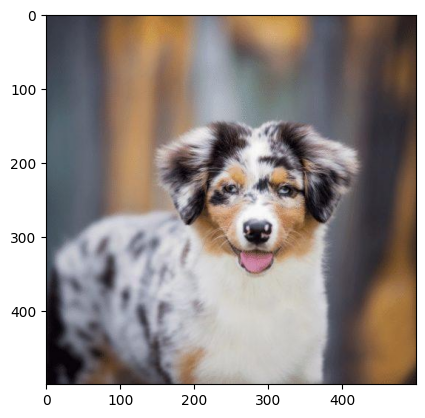

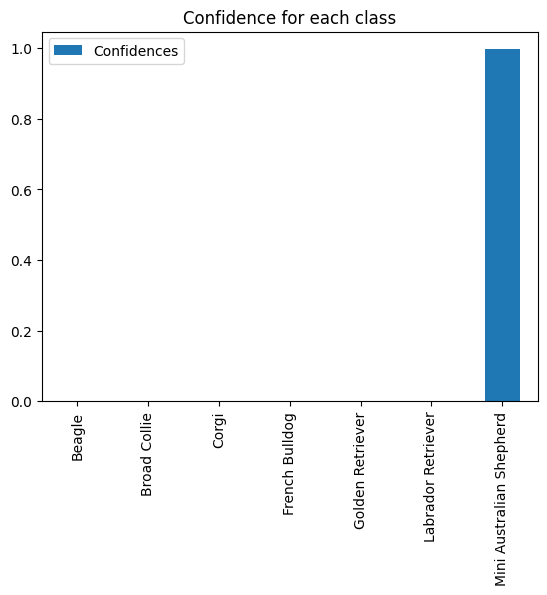

In [ ]:
from PIL import Image

image = Image.open('/content/Dog_Breed_Data/Mini Australian Shepherd/30.blue-merle-aussie.jpg')
plt.imshow(image)


x = transform(image)
x=x.to(device).unsqueeze(0)

with torch.no_grad():
    model.eval()
    out = model(x)
    _, preds = torch.max(out, 1)

print('This is a {}'.format(class_names[preds]))
sm = torch.nn.Softmax()
confidences = np.array(sm(out.cpu()))
df = pd.DataFrame({'Confidences':confidences[0]},index=class_names)
df.plot.bar()
plt.title('Confidence for each class')

In [ ]:
out

tensor([[-1.8425,  1.1472,  1.5494, -4.7247, -1.6199, -2.3963,  7.9181]],
       device='cuda:0')

## Confusion Matrix Result Analysis

The analysis of the confusion matrix holds significant importance, particularly in scenarios involving more intricate problems beyond classification. Here are a few examples provided for later modification and exploration.

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    val_running_loss = 0.0
    val_running_corrects = 0
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[10.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  5.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  2.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  1.,  0.],
        [ 0.,  1.,  0.,  0.,  1.,  0.,  2.]])


Text(58.2222222222222, 0.5, 'predicted label')

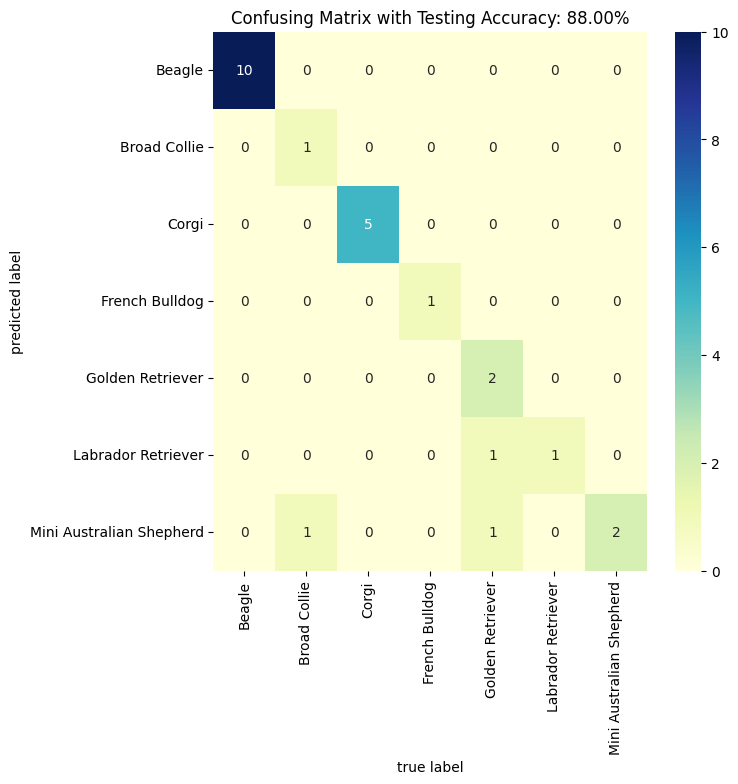

In [ ]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype('int'), index = [i for i in class_names],
                  columns = [i for i in class_names])

test_acc=np.trace(confusion_matrix.numpy().astype('int'))/np.sum(np.sum(df_cm))

plt.figure(figsize = (len(class_names),len(class_names)))
plt.title('Confusing Matrix with Testing Accuracy: {:0.2f}%'.format(test_acc*100))

sn.heatmap(df_cm, annot=True,fmt='g',cmap="YlGnBu")
plt.xlabel('true label')
plt.ylabel('predicted label')
# plt.savefig(model_name+'Confusing Matrix.png')

## Student Excercise

Now we can do some excercise to make sure we can follow. Use the `test_dataloader` to calculate the total y_true and y_pred. Then use the confustion matrix from Day 1 to generate a confusion matrix similar to above. Meanwhile, study the validation code and calculate the loss and accuracy. Good luck.

In [ ]:
model.eval()   # Set model to evaluate mode
test_running_loss = 0.0
test_running_corrects = 0
y_true=torch.tensor([])
y_pred=torch.tensor([])
# Iterate over data.
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = FIXME
    _, preds = FIXME
    loss = FIXME

    # appending preds and labels from each batch to total. Do not worry about the following part.
    y_pred=torch.cat((y_pred,preds))
    y_true=torch.cat((y_true,labels))
    # statistics
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

test_epoch_loss = test_running_loss / len(test_set)
test_accuracy = test_running_corrects.double() / len(test_set)
print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {test_epoch_loss:.4f}, validation Accuracy: {test_accuracy:.2f}%")

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

confusion_mtx = confusion_matrix(FIXME)

sns.heatmap(confusion_mtx,square=True, annot=True,fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)

NameError: ignored

## Discussion of Results

The results clearly demonstrated the advantage of transfer learning, especially when dealing with limited labeled data. The model trained with pre-trained weights achieved better performance, higher confidence levels in predictions, and showed improved results during visualization. The confidence bar graphs also provided insights into the model's confidence in its predictions.

## Summary

In this lab on Transfer Learning, we explored the concept and benefits of leveraging pre-trained models for related tasks. Transfer learning involves reusing a model trained on one task or domain and adapting it to another, avoiding the need to train a new model from scratch. We focused on using the PyTorch framework and loaded the ResNet-18 model with pre-trained weights. By fine-tuning this pre-trained model, we trained it to classify different dog breeds. The training process was compared between using pre-trained weights and starting from scratch.